**Description:**

This notebook reuses the functions from `EXP-23-BZ3167.ipynb` to process **Omnipose**-generated segmentation masks and extract bacterial growth measurements.

The areas are loaded, and the rolling-window exponential model $$ A(t) = a e^{b t}$$
is applied to obtain growth-rate values from the fitted parameter \( b \).

The same procedure is applied to both the reference and treatment data. After the growth rates are computed for all positions, the mean, standard deviation, and SEM at each time point are calculated, and the treatment growth-rate curves are normalized to the reference mean.

The output includes plots of area curves, growth-rate curves, and a final normalized growth-rate figure with the drug-addition time indicated.

**A new addition in this notebook is the computation of the detection time**, which identifies the <ins> earliest point at which the treatment curve diverges from the reference </ins>. This visualization shows how and when the treatment growth rate differs from the reference condition.

The data folders used in this analysis were uploaded to **Google Drive**.

In [1]:
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import pickle
from pathlib import Path
from scipy.stats import ttest_ind

# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions provided from `EXP-23-BZ3167.ipynb`

## Exponential Growth Model

In [2]:
def exp_growth_fit(x, a, b):
    """
    Exponential growth model: Area = a * exp(b * x)
    """
    return a * np.exp(b * x)


## Area Calculation From Mask

In [3]:
def calculate_area_from_mask(mask):
    """
    Calculate total bacterial area from segmentation mask
    Args:
        mask: Segmentation mask where:
              0 = background
              1, 2, 3, ... = individual bacteria

    Returns:
        total_area: Total bacterial area in pixels
    """
    # Count pixels for each unique value in mask
    npoints = np.unique(mask, return_counts=True)[1][1:]  # Skip background (0)

    # Sum all bacterial pixels
    total_area = sum(npoints)

    return total_area


## Growth Rate Calculation

In [4]:
def calculate_growth_rate_rolling(rolling_number, interval_time, area_data):
    """
    Calculate growth rate using sliding window exponential fit
    Each window of area measurements is fitted to Area = a * exp(b * time),
    and the growth rate (b) is extracted from the smooth fitted curve.

    Args:
        rolling_number: Window size (number of frames)
        interval_time: Time between frames (minutes),
        area_data: Array of bacterial areas in pixels,

    Returns:
        growth_rate_rollings: Array of growth rates in h⁻¹
                             Length = len(area_data) - rolling_number + 1
                             For 121 frames with window=16: 106 values
    """
    growth_rate_rollings = []

    # Slide window through data starting at frame 'rolling_number'
    for i in range(rolling_number, len(area_data)):
        if i >= rolling_number:
            # Extract time window
            time_rolling = [time for time in range(i-rolling_number, i)]

            # Extract area window
            area_rolling = [value for value in area_data[i-rolling_number:i]]

            # Initial parameter guess for curve_fit
            p0 = [1, 0.0005]  # [a, b]

            # Fit exponential: Area = a * exp(b * time)
            # This step smooths the data by fitting a curve through the points
            popt, _ = curve_fit(exp_growth_fit, time_rolling, area_rolling, p0=p0)

            # Extract growth rate (b) and convert to h⁻¹
            # popt[0] = a (initial area)
            # popt[1] = b (growth rate per frame)
            growth_rate_h = popt[1] / interval_time * 60

            growth_rate_rollings.append(growth_rate_h)

    return growth_rate_rollings

## Additional smoothing

In [5]:
def fit_exponential(data, rolling_number, divisor):
    """
    Apply additional exponential fitting to smooth area data
    This removes outliers BEFORE growth rate calculation

    Args:
        data: Array of area values
        rolling_number: Window size (typically 16)
        divisor: Chunk size divisor (2, 1, or 0.5 in original)

    Returns:
        result: Smoothed area array (same length as input)
    """
    fitted_chunk = int(rolling_number / divisor)

    # Define exponential function
    def exponential(x, a, b):
        return a * np.exp(b * x)

    # Check if value fits well with fitted exponential
    def is_good_fit(x, y, a, b, threshold=0.05):
        fitted_value = exponential(x, a, b)
        return abs((y - fitted_value) / y) <= threshold

    result = []

    # Loop over data in chunks
    for i in range(0, len(data)-1, fitted_chunk):
        chunk = data[i:i+fitted_chunk]

        # Fit exponential to chunk
        try:
            popt, _ = curve_fit(exponential, range(len(chunk)), chunk, maxfev=5000)
        except RuntimeError:
            # Fitting failed, just append chunk as is
            result.extend(chunk)
            continue

        # Check each value in chunk
        for j, value in enumerate(chunk):
            if not is_good_fit(j, value, *popt):
                # Replace outlier with fitted value
                chunk[j] = exponential(j, *popt)

        result.extend(chunk)

    return result

## Statistical Functions

In [6]:
def find_means_std_sem(data):
    """
    Calculate mean, standard deviation, and standard error of mean
    Args:
        data: List of arrays (one per chamber)

    Returns:
        means: Mean across chambers
        std: Standard deviation (with ddof=1)
        sem: Standard error of mean
    """
    stacked_data = np.vstack(data)
    stacked_data_means = np.mean(stacked_data, axis=0)
    stacked_data_std_dev = np.std(stacked_data, axis=0, ddof=1)
    stacked_data_std_err = stats.sem(stacked_data, axis=0, ddof=1)

    return stacked_data_means, stacked_data_std_dev, stacked_data_std_err


## Normalization

In [7]:
def normalize_lists(list_a, list_b):
    """
    Normalize list_a by list_b: returns list_a / list_b
    """
    if len(list_a) != len(list_b):
        raise ValueError("Lists must have the same length")

    normalized_result = [a / b if b != 0 else 0 for a, b in zip(list_a, list_b)]

    return normalized_result

## Plotting Functions

In [8]:
def plot_area_growth(corrected_areas_plot, interval_time, num_frame,
                     corrected_areas_column_means, corrected_areas_column_std_dev,
                     corrected_areas_column_std_err, color):
    """
    Plot area growth over time with mean±SD and mean±SEM bands
    Args:
        corrected_areas_plot: Stacked area data (chambers × timepoints) in μm²
        interval_time: Minutes between frames
        num_frame: Number of frames
        corrected_areas_column_means: Mean area in μm²
        corrected_areas_column_std_dev: Standard deviation
        corrected_areas_column_std_err: Standard error of mean
        color: Color for lines (e.g., '#009ADE' for REF)
    """
    # Time axis (starts at -1 hour, drug added at 0)
    time_plot = [time*(interval_time/60) - 1 for time in range(0, num_frame)]

    plt.figure(facecolor='white')

    # Drug addition line
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')

    # Individual chamber traces
    plt.plot(time_plot, corrected_areas_plot.T, lw=0.5, alpha=0.3)

    # Mean line
    plt.plot(time_plot, corrected_areas_column_means, lw=3, color=color)

    # Mean ± SD band
    plt.fill_between(time_plot,
                     corrected_areas_column_means - corrected_areas_column_std_dev,
                     corrected_areas_column_means + corrected_areas_column_std_dev,
                     label='Mean±SD', alpha=0.3, color=color)

    # Mean ± SEM band
    plt.fill_between(time_plot,
                     corrected_areas_column_means - corrected_areas_column_std_err,
                     corrected_areas_column_means + corrected_areas_column_std_err,
                     label='Mean±SEM', alpha=0.7, color=color)

    plt.xlabel('Time (hour)')
    plt.ylabel('Area' + r' ($\mu m^2$) ')
    plt.title('Area growth')
    plt.legend()

def plot_growth_curve(stacked_growth_data, interval_time, rolling_number, num_frame,
                      growth_mean, growth_std, growth_sem, color):
    """
    Plot growth rate over time with mean±SD and mean±SEM bands

    Args:
        stacked_growth_data: Stacked growth rate data (chambers × timepoints)
        interval_time: Minutes between frames (usually 2)
        rolling_number: Window size used for growth rate calculation
        num_frame: Number of growth rate values
        growth_mean: Mean growth rate
        growth_std: Standard deviation
        growth_sem: Standard error of mean
        color: Color for lines
    """
    # Time axis (accounts for rolling window)
    time_plot_growth = [time*(interval_time/60) - 1 for time in range(0, num_frame + rolling_number)]

    plt.figure(facecolor='white')

    # Drug addition line
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')

    # Individual chamber traces
    plt.plot(time_plot_growth[rolling_number:], stacked_growth_data.T, lw=0.5, alpha=0.2)

    # Mean line
    plt.plot(time_plot_growth[rolling_number:], growth_mean, lw=2, alpha=0.8, color=color)

    # Mean ± SD band
    plt.fill_between(time_plot_growth[rolling_number:],
                     growth_mean - growth_std,
                     growth_mean + growth_std,
                     label='Mean±SD', alpha=0.3, color=color)

    # Mean ± SEM band
    plt.fill_between(time_plot_growth[rolling_number:],
                     growth_mean - growth_sem,
                     growth_mean + growth_sem,
                     label='Mean±SEM', alpha=0.5, color=color)

    plt.xlabel('Time (hour)')
    plt.ylabel('Growth rate ' + r' ($h^{-1}$) ')
    plt.title('Growth rate')
    plt.ylim(-0.5, 1)
    plt.legend()

def plot_growth_curve_two(stacked_growth_data, interval_time, rolling_number, num_frame,
                          growth_mean, growth_std, growth_sem,
                          stacked_growth_data2, growth_mean2, growth_std2, growth_sem2,
                          color, color2):
    """
    Plot both REF and treatment growth rates on same axes

    Args:
        stacked_growth_data: First dataset (REF)
        growth_mean, growth_std, growth_sem: Statistics for first dataset
        stacked_growth_data2: Second dataset (RIF10)
        growth_mean2, growth_std2, growth_sem2: Statistics for second dataset
        color: Color for first dataset
        color2: Color for second dataset
    """
    time_plot_growth = [time*(interval_time/60) - 1 for time in range(0, num_frame + rolling_number)]

    plt.figure(facecolor='white')
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')

    # First dataset
    plt.plot(time_plot_growth[rolling_number:], growth_mean, lw=2, alpha=0.8, color=color)
    plt.fill_between(time_plot_growth[rolling_number:], growth_mean - growth_sem,
                     growth_mean + growth_sem, alpha=0.5, color=color)

    # Second dataset
    plt.plot(time_plot_growth[rolling_number:], growth_mean2, lw=2, alpha=0.8, color=color2)
    plt.fill_between(time_plot_growth[rolling_number:], growth_mean2 - growth_sem2,
                     growth_mean2 + growth_sem2, alpha=0.5, color=color2)

    plt.xlabel('Time (hour)')
    plt.ylabel('Growth rate ' + r' ($h^{-1}$) ')
    plt.title('Growth rate')
    plt.ylim(-0.2, 0.4)
    plt.legend()

def plot_normalized_growth_rate(time_plot_growth, rolling_number,
                                normalized_ref_means, normalized_ref_sem,
                                normalized_treat_means, normalized_treat_sem,
                                title="Normalized growth rate"):
    """
    Plot normalized growth rate comparing REF and treatment

    Args:
        time_plot_growth: Time array
        rolling_number: Window size
        normalized_ref_means: REF normalized to 1.0
        normalized_ref_sem: REF SEM
        normalized_treat_means: Treatment / REF
        normalized_treat_sem: Treatment SEM
        title: Plot title
    """
    plt.figure(facecolor='white')

    # Drug addition line
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')

    # Reference (blue) - normalized to 1.0
    plt.plot(time_plot_growth[rolling_number:], normalized_ref_means,
             label='Reference(Mean±SEM)', color='#009ADE')
    plt.fill_between(time_plot_growth[rolling_number:],
                     normalized_ref_means - normalized_ref_sem,
                     normalized_ref_means + normalized_ref_sem,
                     alpha=0.3, color='#009ADE')

    # Treatment (pink)
    plt.plot(time_plot_growth[rolling_number:], normalized_treat_means,
             label='Treatment(Mean±SEM)', color='#FF1F5B')
    plt.fill_between(time_plot_growth[rolling_number:],
                     normalized_treat_means - normalized_treat_sem,
                     normalized_treat_means + normalized_treat_sem,
                     alpha=0.3, color='#FF1F5B')

    # Labels
    plt.xlabel('Time (h)')
    plt.ylabel('Normalized growth rate')
    plt.legend()
    plt.title(title)
    plt.ylim(-0.5, 1.4)


## Data Loading

In [ ]:
def load_data(main_dir, all_positions, empty_positions):
    # Filter out empty positions
    positions = [pos for pos in all_positions if pos not in empty_positions]

    list_position_dirs = []
    # Construct the folder name
    for position in positions:
        if position < 100:
            dir_string = 'Pos0' + str(position)
        else:
            dir_string = 'Pos' + str(position)

        directory = os.path.join(main_dir, dir_string)
        list_position_dirs.append(directory)

    # Name of the subfolder containing the Omnipose mask outputs
    phase_dir_name = 'PreprocessedPhaseMasks'
    # Lists for collecting all area and growth-rate pickles
    merged_areas_growth_data = []
    merged_growth_rate_data = []

    for position_directory in list_position_dirs:
        folder_list = os.listdir(position_directory)
        # Find the mask output folder inside each position directory
        for folder_name in folder_list:
            if folder_name == phase_dir_name:
                input_dir = os.path.join(position_directory, folder_name)
                file_list = os.listdir(input_dir)
                # Load the pickle files containing area and growth-rate data
                for file_name in file_list:
                    # Load area files
                    if file_name.endswith('growth_areas.pickle'):
                        areas_file_path = os.path.join(input_dir, file_name)
                        with open(areas_file_path, 'rb') as f:
                            areas_growth_data = pickle.load(f)
                            merged_areas_growth_data.append(areas_growth_data)
                    # Load growth-rate files
                    if file_name.endswith('growth_rate.pickle'):
                        growth_rate_file_path = os.path.join(input_dir, file_name)
                        with open(growth_rate_file_path, 'rb') as f:
                            growth_rate_data = pickle.load(f)
                            merged_growth_rate_data.append(growth_rate_data)

    return merged_areas_growth_data, merged_growth_rate_data

# Recreation of the plots in `EXP-23-BZ3167.ipynb`

The plots will differ slightly because we processe a smaller subset of positions (101–110 and 201–210) instead of the full ranges used originally (101–132 and 201–232).



The following cell is obtained from the `EXP-23-BZ3167.ipynb` :


REF Areas:
  Mean area: 138.69 μm²


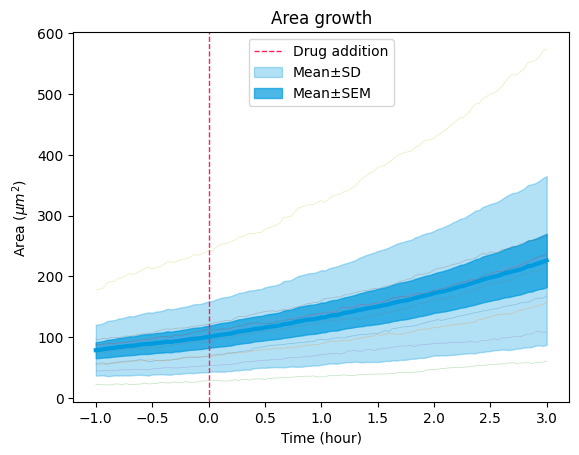


REF Growth Rates:
  Mean growth rate: 0.258 h⁻¹


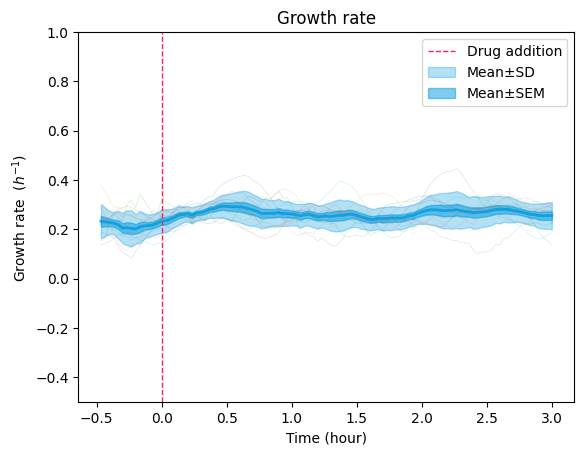


RIF10 Areas:
  Mean area: 159.45 μm²


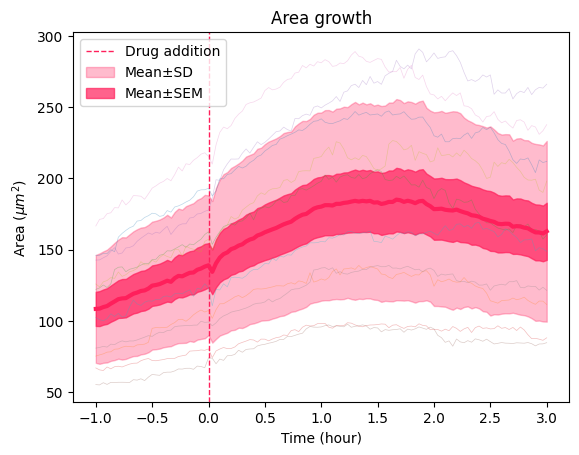


RIF10 Growth Rates:
  Mean growth rate: 0.103 h⁻¹


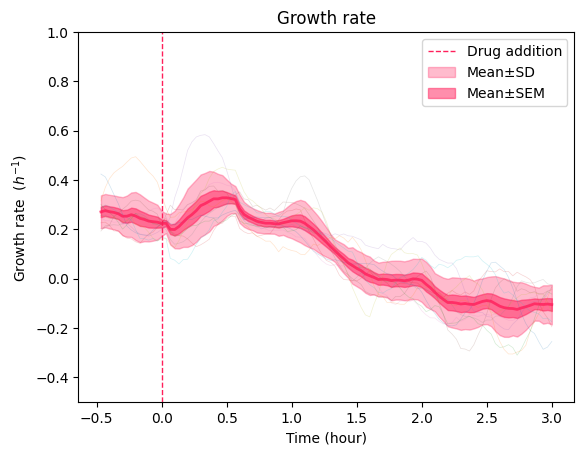

In [14]:
#Experiment parameters
rolling_number = 16 #number of data points for fitting M. smegmatis (2 mins intervals for 4 hours) (rolling of 16 points = 30 min)
interval_time = 2 #interval between frames in minutes
pixel_area = 0.0733**2 #the pixel size is 73.3 nm at 100x*1.5x magnification in Nikon6

ref_dir = "/content/drive/MyDrive/REF_masks101_110"
treat_dir = "/content/drive/MyDrive/RIF10_masks201_210"

ref_all_positions = list(range(101, 111))
ref_empty_positions = []

treat_all_positions = list(range(201, 211))
treat_empty_positions = []

# Load area and growth-rate pickles
ref_areas_data, ref_growth_rate_data = load_data(ref_dir, ref_all_positions, ref_empty_positions)
treat_areas_data, treat_growth_rate_data = load_data(treat_dir, treat_all_positions, treat_empty_positions)

# Reference condition
# Convert pixel areas to µm²
ref_areas_data = np.vstack(ref_areas_data) * pixel_area
# plot area
ref_areas_means, ref_areas_std, ref_areas_sem = find_means_std_sem(ref_areas_data)
num_pos_areas, num_frame_areas = ref_areas_data.shape
print(f"\nREF Areas:")
print(f"  Mean area: {np.mean(ref_areas_means):.2f} μm²")
plot_area_growth(ref_areas_data, interval_time, num_frame_areas, ref_areas_means, ref_areas_std, ref_areas_sem, color='#009ADE') ##0D4A70
plt.show()

# calculate and plot growth rate
ref_growth_rates = []
for pos_area in ref_areas_data:
   # Compute growth rate for each position
    ref_pos_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area)
    ref_growth_rates.append(ref_pos_growth_rate)
# Compute population-level statistics
ref_growth_means, ref_growth_std, ref_growth_sem = find_means_std_sem(ref_growth_rates)

stacked_ref_growth_rates = np.vstack(ref_growth_rates)
num_pos, num_frame = stacked_ref_growth_rates.shape
print(f"\nREF Growth Rates:")
print(f"  Mean growth rate: {np.mean(ref_growth_means):.3f} h⁻¹")
plot_growth_curve(stacked_ref_growth_rates, interval_time, rolling_number, num_frame, ref_growth_means, ref_growth_std, ref_growth_sem, color = '#009ADE')
plt.show()

#####################################################################################
# Treatment condition
# Convert pixel areas to µm²
treat_areas_data = np.vstack(treat_areas_data) * pixel_area

# plot area
treat_areas_means, treat_areas_std, treat_areas_sem = find_means_std_sem(treat_areas_data)
num_pos_areas, num_frame_areas = treat_areas_data.shape
print(f"\nRIF10 Areas:")
print(f"  Mean area: {np.mean(treat_areas_means):.2f} μm²")
plot_area_growth(treat_areas_data, interval_time, num_frame_areas, treat_areas_means, treat_areas_std, treat_areas_sem, color='#FF1F5B')
plt.show()

# Calculate and plot growth rates
treat_growth_rates = []
for pos_area in treat_areas_data:
    treat_pos_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area)
    treat_growth_rates.append(treat_pos_growth_rate)

treat_growth_means, treat_growth_std, treat_growth_sem = find_means_std_sem(treat_growth_rates)

stacked_treat_growth_rates = np.vstack(treat_growth_rates)
num_pos, num_frame = stacked_treat_growth_rates.shape
print(f"\nRIF10 Growth Rates:")
print(f"  Mean growth rate: {np.mean(treat_growth_means):.3f} h⁻¹")
plot_growth_curve(stacked_treat_growth_rates, interval_time, rolling_number, num_frame, treat_growth_means, treat_growth_std, treat_growth_sem, color = '#FF1F5B')
plt.show()


The detection time is obtained by comparing the raw growth-rate values from each chamber in the untreated and treated conditions.

At every time point after drug addition, the two distributions (one growth-rate value per chamber) are evaluated using  **Welch two-sample t-test**.

The detection time
𝑇
 is defined as the earliest time point at which <ins> the difference between treated and untreated growth rates is statistically significant (p < 0.05) </ins>.

In [15]:
# Determine the common time length shared by REF and TREAT datasets
min_len_orig = min(
    stacked_ref_growth_rates.shape[1],
    stacked_treat_growth_rates.shape[1]
)
# Trim both datasets to the same length for statistical comparison
ref_orig_trim   = stacked_ref_growth_rates[:, :min_len_orig]
treat_orig_trim = stacked_treat_growth_rates[:, :min_len_orig]

# Compute p-values over time
p_values_orig = []
for t in range(min_len_orig):
    # Welch’s t-test (unequal variances) at each timepoint
    stat, p = ttest_ind(ref_orig_trim[:, t], treat_orig_trim[:, t], equal_var=False)
    p_values_orig.append(p)

p_values_orig = np.array(p_values_orig)

# Corresponding time axis (growth-rate windows start after rolling_number)
time_growth_orig = np.array([
    time*(interval_time/60) - 1
    for time in range(rolling_number, rolling_number + min_len_orig)
])

# Identify timepoints after drug exposure (t >= 0)
post_drug_idx_orig = np.where(time_growth_orig >= 0)[0]

# Find the first timepoint where REF vs TREAT become significantly different
sig_idx_orig = post_drug_idx_orig[p_values_orig[post_drug_idx_orig] < 0.05]

if len(sig_idx_orig) == 0:
    # No statistically significant divergence detected
    T_detect_orig = None
    print("Original growth-rate data: No significant detection (p < 0.05).")
else:
   # First significant timepoint defines the detection time T*
    first_idx_orig = sig_idx_orig[0]
    T_detect_orig = time_growth_orig[first_idx_orig]
    print(f"Detection time (original growth rates): T* = {T_detect_orig:.2f} hours")

Detection time (original growth rates): T* = 1.20 hours


The following cell is obtained from the `EXP-23-BZ3167.ipynb` to normalize reference and treatment statistics to the reference mean:

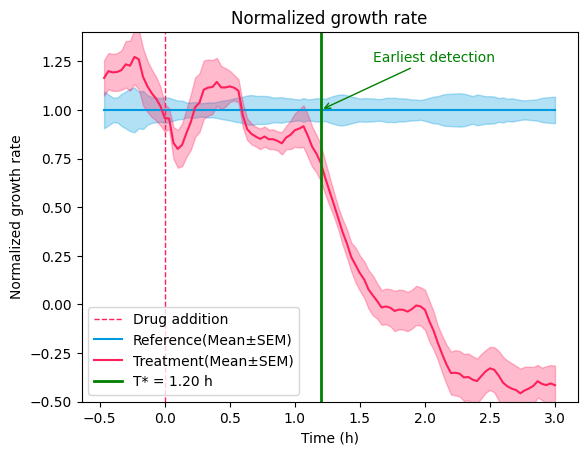

In [16]:
# Normalize reference statistics to the reference mean
normalized_ref_ref_means = normalize_lists(ref_growth_means,ref_growth_means)
normalized_ref_ref_means = np.array(normalized_ref_ref_means)

normalized_ref_ref_std = normalize_lists(ref_growth_std,ref_growth_means)
normalized_ref_ref_std = np.array(normalized_ref_ref_std)

normalized_ref_ref_sem = normalize_lists(ref_growth_sem,ref_growth_means)
normalized_ref_ref_sem = np.array(normalized_ref_ref_sem)

# Normalize treatment statistics to the reference mean
normalized_treat_ref_means = normalize_lists(treat_growth_means,ref_growth_means)
normalized_treat_ref_means = np.array(normalized_treat_ref_means)

normalized_treat_ref_std = normalize_lists(treat_growth_std,ref_growth_means)
normalized_treat_ref_std = np.array(normalized_treat_ref_std)

normalized_treat_ref_sem = normalize_lists(treat_growth_sem,ref_growth_means)
normalized_treat_ref_sem = np.array(normalized_treat_ref_sem)

# Time axis for plotting (in hours), shifted so drug addition occurs at t = 0
time_plot_growth = [time*(interval_time/60)-1 for time in range(0, num_frame+rolling_number)]

# Plot normalized growth-rate curves
plt.figure(facecolor='white')
# Add a vertical line at x=0
plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
plt.plot(time_plot_growth[rolling_number:], normalized_ref_ref_means, label='Reference(Mean±SEM)', color = '#009ADE')
plt.fill_between(time_plot_growth[rolling_number:], normalized_ref_ref_means - normalized_ref_ref_sem, normalized_ref_ref_means + normalized_ref_ref_sem, alpha=0.3, color = '#009ADE')
plt.plot(time_plot_growth[rolling_number:], normalized_treat_ref_means, label='Treatment(Mean±SEM)', color = '#FF1F5B')
plt.fill_between(time_plot_growth[rolling_number:], normalized_treat_ref_means - normalized_treat_ref_sem, normalized_treat_ref_means + normalized_treat_ref_sem, alpha=0.3, color = '#FF1F5B')
# Add the green T* arrow
if T_detect_orig is not None:
    plt.axvline(x=T_detect_orig, color='green', lw=2, label=f"T* = {T_detect:.2f} h")
    plt.annotate(
        "Earliest detection",
        xy=(T_detect_orig, 1.0),
        xytext=(T_detect_orig + 0.4, 1.25),
        arrowprops=dict(arrowstyle="->", color="green"),
        color="green"
    )
plt.xlabel('Time (h)')
plt.ylabel('Normalized growth rate')
plt.legend()
plt.title('Normalized growth rate')
plt.ylim(-0.5,1.4)
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_NORMALIZED-Growth_rate.svg"))
plt.show()

## Additional Smooting (optional)

This section fits smooth exponential curves to the raw area data for each chamber in both the reference and treatment conditions. The fitted area values are then used to recalculate growth rates using the same rolling-window exponential method applied earlier.

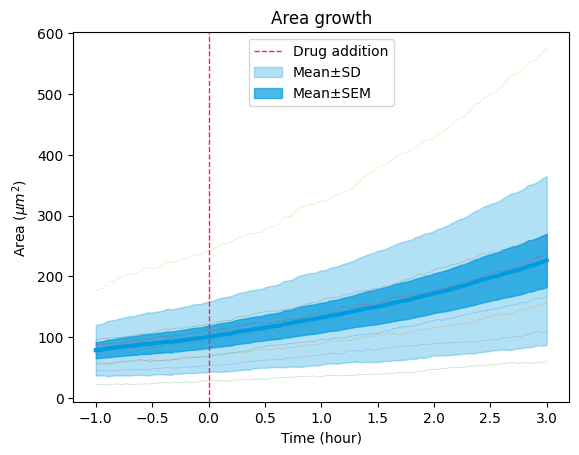

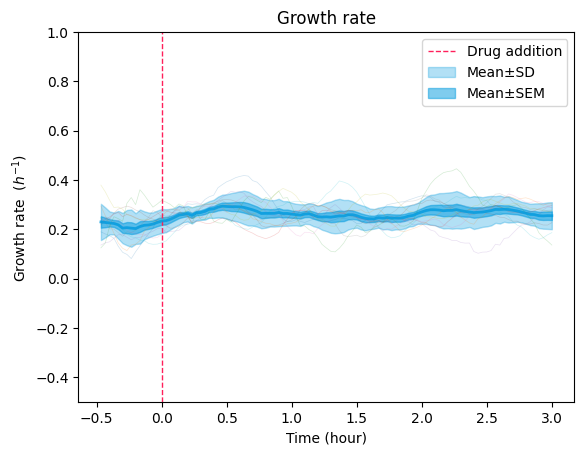

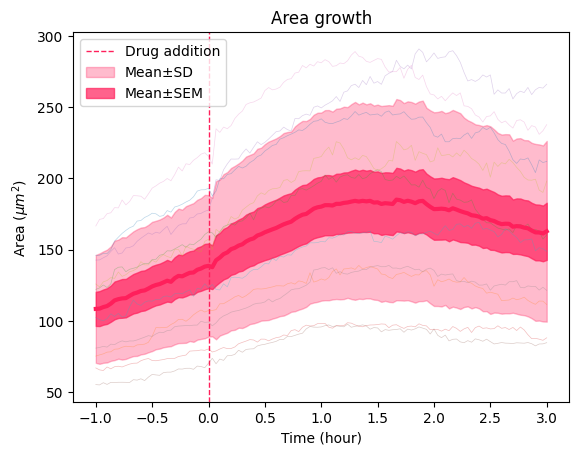

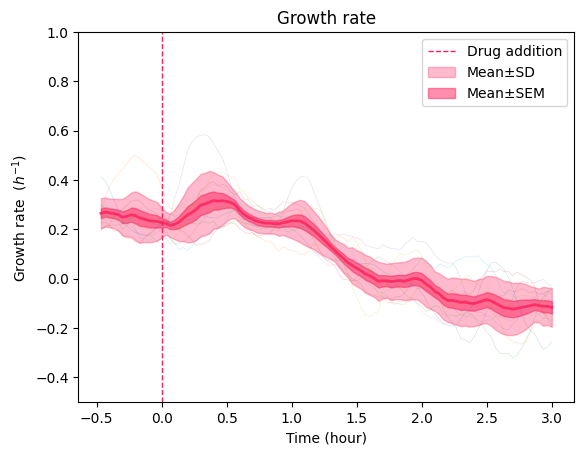

In [17]:
# Reference condition: fit area curves using exponential smoothing
ref_fit_areas = []
for pos_area in ref_areas_data:
    ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 2)
    ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 1)
    ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 0.5)
    ref_fit_areas.append(ref_pos_fit_area)

ref_fit_areas_means, ref_fit_areas_std, ref_fit_areas_sem = find_means_std_sem(ref_fit_areas)
stacked_fit_areas = np.vstack(ref_fit_areas)
num_pos_fit_areas, num_frame_fit_areas = stacked_fit_areas.shape
plot_area_growth(stacked_fit_areas, interval_time, num_frame_fit_areas, ref_fit_areas_means, ref_fit_areas_std, ref_fit_areas_sem, color='#009ADE')
plt.show()

#calculate and plot growth rate
ref_fit_growth_rates = []
for pos_area_fit in stacked_fit_areas:
    ref_pos_fit_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area_fit)
    ref_fit_growth_rates.append(ref_pos_fit_growth_rate)

ref_fit_growth_means, ref_fit_growth_std, ref_fit_growth_sem = find_means_std_sem(ref_fit_growth_rates)

stacked_ref_fit_growth_rates = np.vstack(ref_fit_growth_rates)
num_pos_fit, num_frame_fit = stacked_ref_fit_growth_rates.shape

plot_growth_curve(stacked_ref_fit_growth_rates, interval_time, rolling_number, num_frame_fit, ref_fit_growth_means, ref_fit_growth_std, ref_fit_growth_sem, color = '#009ADE')
plt.show()

# Calculate and plot growth rates (from fitted area data)
treat_fit_areas = []
for pos_area in treat_areas_data:
    treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 2)
    treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 1)
    treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 0.5)
    treat_fit_areas.append(treat_pos_fit_area)

treat_fit_areas_means, treat_fit_areas_std, treat_fit_areas_sem = find_means_std_sem(treat_fit_areas)
treat_stacked_fit_areas = np.vstack(treat_fit_areas)
num_pos_fit_areas, num_frame_fit_areas = treat_stacked_fit_areas.shape
plot_area_growth(treat_stacked_fit_areas, interval_time, num_frame_fit_areas, treat_fit_areas_means, treat_fit_areas_std, treat_fit_areas_sem, color='#FF1F5B')
plt.show()

#calculate and plot growth rate
treat_fit_growth_rates = []
for pos_area_fit in treat_stacked_fit_areas:
    treat_pos_fit_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area_fit)
    treat_fit_growth_rates.append(treat_pos_fit_growth_rate)

treat_fit_growth_means, treat_fit_growth_std, treat_fit_growth_sem = find_means_std_sem(treat_fit_growth_rates)

stacked_treat_fit_growth_rates = np.vstack(treat_fit_growth_rates)
num_pos_fit, num_frame_fit = stacked_treat_fit_growth_rates.shape

plot_growth_curve(stacked_treat_fit_growth_rates, interval_time, rolling_number, num_frame_fit, treat_fit_growth_means, treat_fit_growth_std, treat_fit_growth_sem, color = '#FF1F5B')
plt.show()


In [18]:
# Detection time

min_len_fit = min(
    stacked_ref_fit_growth_rates.shape[1],
    stacked_treat_fit_growth_rates.shape[1]
)

ref_fit_trim   = stacked_ref_fit_growth_rates[:, :min_len_fit]
treat_fit_trim = stacked_treat_fit_growth_rates[:, :min_len_fit]

# Compute p-values
p_values_fit = []
for t in range(min_len_fit):
    stat, p = ttest_ind(ref_fit_trim[:, t], treat_fit_trim[:, t], equal_var=False)
    p_values_fit.append(p)

p_values_fit = np.array(p_values_fit)

# Time axis for fitted growth rates
time_growth_fit = np.array([
    time*(interval_time/60) - 1
    for time in range(rolling_number, rolling_number + min_len_fit)
])

post_drug_idx_fit = np.where(time_growth_fit >= 0)[0]

# First significant timepoint
sig_idx_fit = post_drug_idx_fit[p_values_fit[post_drug_idx_fit] < 0.05]

if len(sig_idx_fit) == 0:
    T_detect_fit = None
    print("Fitted growth-rate data: No significant detection (p < 0.05).")
else:
    first_idx_fit = sig_idx_fit[0]
    T_detect_fit = time_growth_fit[first_idx_fit]
    print(f"Detection time (fitted growth rates): T* = {T_detect_fit:.2f} hours")


Detection time (fitted growth rates): T* = 1.20 hours


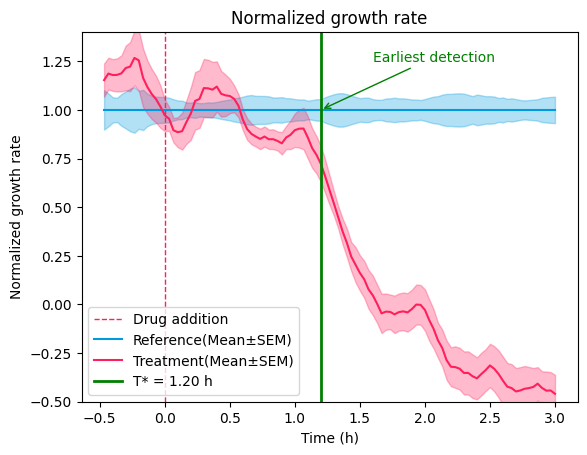

In [19]:
#normalization of reference means, standard deviations, SEMs to the reference means
normalized_fit_ref_ref_means = normalize_lists(ref_fit_growth_means,ref_fit_growth_means)
normalized_fit_ref_ref_means = np.array(normalized_fit_ref_ref_means)

normalized_fit_ref_ref_std = normalize_lists(ref_fit_growth_std,ref_fit_growth_means)
normalized_fit_ref_ref_std = np.array(normalized_fit_ref_ref_std)

normalized_fit_ref_ref_sem = normalize_lists(ref_fit_growth_sem,ref_fit_growth_means)
normalized_fit_ref_ref_sem = np.array(normalized_fit_ref_ref_sem)

#normalization of treatment means, standard deviations, SEMs to the reference means
normalized_fit_treat_ref_means = normalize_lists(treat_fit_growth_means,ref_fit_growth_means)
normalized_fit_treat_ref_means = np.array(normalized_fit_treat_ref_means)

normalized_fit_treat_ref_std = normalize_lists(treat_fit_growth_std,ref_fit_growth_means)
normalized_fit_treat_ref_std = np.array(normalized_fit_treat_ref_std)

normalized_fit_treat_ref_sem = normalize_lists(treat_fit_growth_sem,ref_fit_growth_means)
normalized_fit_treat_ref_sem = np.array(normalized_fit_treat_ref_sem)

time_plot_growth = [time*(interval_time/60)-1 for time in range(0, num_frame+rolling_number)]

plt.figure(facecolor='white')
# Add a vertical line at x=0
plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
plt.plot(time_plot_growth[rolling_number:], normalized_fit_ref_ref_means, label='Reference(Mean±SEM)', color = '#009ADE')
plt.fill_between(time_plot_growth[rolling_number:], normalized_fit_ref_ref_means - normalized_fit_ref_ref_sem, normalized_fit_ref_ref_means + normalized_fit_ref_ref_sem, alpha=0.3, color = '#009ADE')
plt.plot(time_plot_growth[rolling_number:], normalized_fit_treat_ref_means, label='Treatment(Mean±SEM)', color = '#FF1F5B')
plt.fill_between(time_plot_growth[rolling_number:], normalized_fit_treat_ref_means - normalized_fit_treat_ref_sem, normalized_fit_treat_ref_means + normalized_fit_treat_ref_sem, alpha=0.3, color = '#FF1F5B')
# Add the green T* arrow
if T_detect_fit is not None:
    plt.axvline(x=T_detect_fit, color='green', lw=2, label=f"T* = {T_detect:.2f} h")
    plt.annotate(
        "Earliest detection",
        xy=(T_detect_fit, 1.0),
        xytext=(T_detect_fit + 0.4, 1.25),
        arrowprops=dict(arrowstyle="->", color="green"),
        color="green"
    )

plt.xlabel('Time (h)')
plt.ylabel('Normalized growth rate')
plt.legend()
plt.title('Normalized growth rate')
plt.ylim(-0.5,1.4)
plt.show()